In [1]:
# import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from prose import FitsManager, Sequence, blocks, FITSImage, Fluxes
from astropy.visualization import ZScaleInterval
from utils import find_nearest_idx

In [2]:
# read images
fits_folder = "./data/images/20250410"
fm = FitsManager(fits_folder)
fm

Parsing FITS:   0%|          | 0/290 [00:00<?, ?it/s]

date telescope filter   type     target  width  height  files
id                                                                     
1   2025-04-10  HPP-ETHZ      G   bias              2916    2187     10
3   2025-04-10  HPP-ETHZ      G   dark              2916    2187     30
8   2025-04-10  HPP-ETHZ      G   flat              2916    2187     36
14  2025-04-10  HPP-ETHZ      G  light  HAT-P-36b   2916    2187    104
15  2025-04-10  HPP-ETHZ      G  light    TrES-2b   2916    2187    110

In [3]:
# pick target
files = fm.observation_files(i = 15)

date telescope filter   type   target  width  height    exposure  \
id                                                                           
15  2025-04-10  HPP-ETHZ      G  light  TrES-2b   2916    2187  120.000000   
3   2025-04-10  HPP-ETHZ      G   dark            2916    2187   17.000000   
4   2025-04-10  HPP-ETHZ      G   dark            2916    2187   34.000000   
5   2025-04-10  HPP-ETHZ      G   dark            2916    2187   51.000000   
6   2025-04-10  HPP-ETHZ      G   dark            2916    2187   68.000000   
7   2025-04-10  HPP-ETHZ      G   dark            2916    2187   85.000000   
2   2025-04-10  HPP-ETHZ      G   dark            2916    2187  102.000000   
1   2025-04-10  HPP-ETHZ      G   bias            2916    2187    0.000000   
8   2025-04-10  HPP-ETHZ      G   flat            2916    2187    1.780586   
11  2025-04-10  HPP-ETHZ      G   flat            2916    2187    2.729744   
12  2025-04-10  HPP-ETHZ      G   flat            2916    2187    6.982013   
13  2025-04-10  HPP-ETHZ      G   flat            2916    2187    9.882026   
9   2025-04-10  HPP-ETHZ      G   flat            2916    2187   13.974140   
10  2025-04-10  HPP-ETHZ      G   flat            2916    2187   19.671984   

    files  
id         
15    110  
3       5  
4       5  
5       4  
6       6  
7       7  
2       3  
1      10  
8      11  
11      9  
12      4  
13      5  
9       4  
10      3

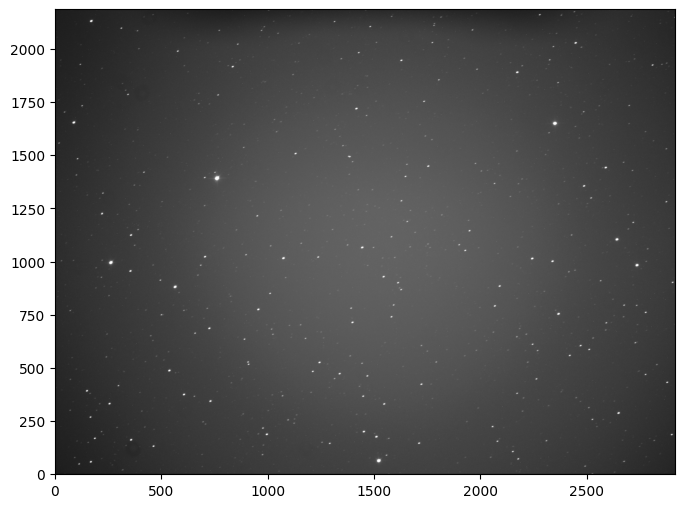

In [4]:
# show example image
FITSImage(files["images"][len(files["images"]) // 2]).show()

In [5]:
# pick reference image to perform calibration sequence
reference_image = FITSImage(files["images"][len(files["images"]) // 2])

calibration_sequence = Sequence(
    [
        blocks.Calibration(
            darks=files["darks"][::2], bias=files["bias"][::2], flats=files["flats"][::2]
        ),
        blocks.Trim(),
        blocks.PointSourceDetection(n=41, saturation=60000),  # stars detection
        blocks.catalogs.PlateSolve(debug=False),
        blocks.catalogs.GaiaCatalog(limit=50),
        blocks.Cutouts(41),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.psf.Gaussian2D(),  # modeling EPSF
    ]
)

  0%|          | 0/1 [00:00<?, ?images/s]

Important: Gaia archive will be intermittently unavailable due to scheduled maintenance (deployment of a new version) on Wednesday 4th from 11h to 12h


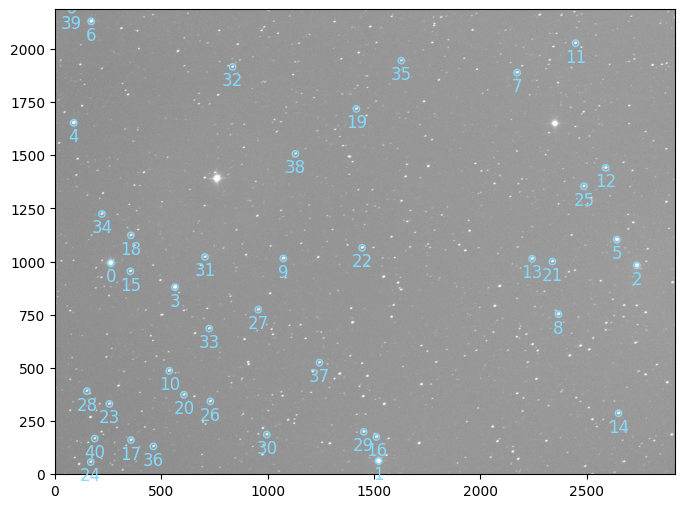

In [6]:
# run calibration sequence
calibration_sequence.run(reference_image)
# show updated reference_image
reference_image.show()

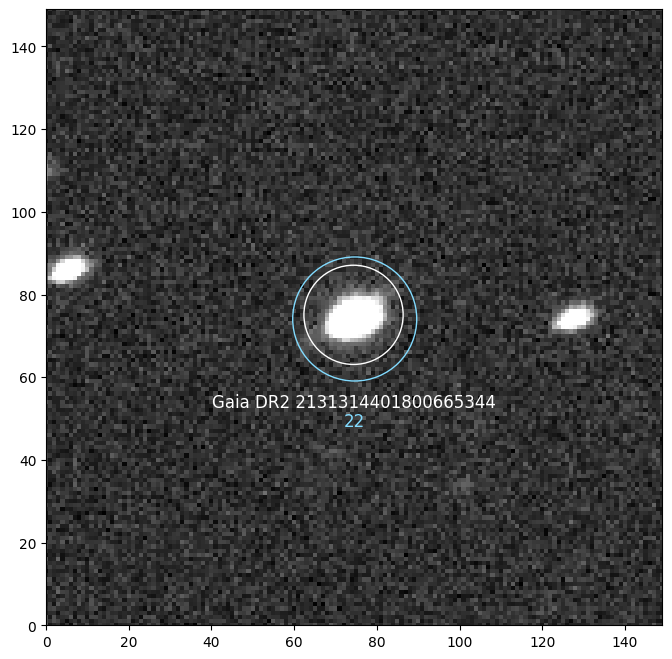

In [7]:
# find target id using Gaia
gaias = reference_image.catalogs["gaia"]["id"]
gaia_id = "Gaia DR2 2131314401800665344" # TrES-2b

match_id = np.where(gaias == gaia_id)
match_coords = reference_image.catalogs["gaia"][["x", "y"]].values[match_id]
target_idx = find_nearest_idx(reference_image.sources.coords, match_coords)

cutout = reference_image.cutout(target_idx, 150, reset_index=False)
cutout.show()
cutout.plot_catalog("gaia", label=True, color="w")

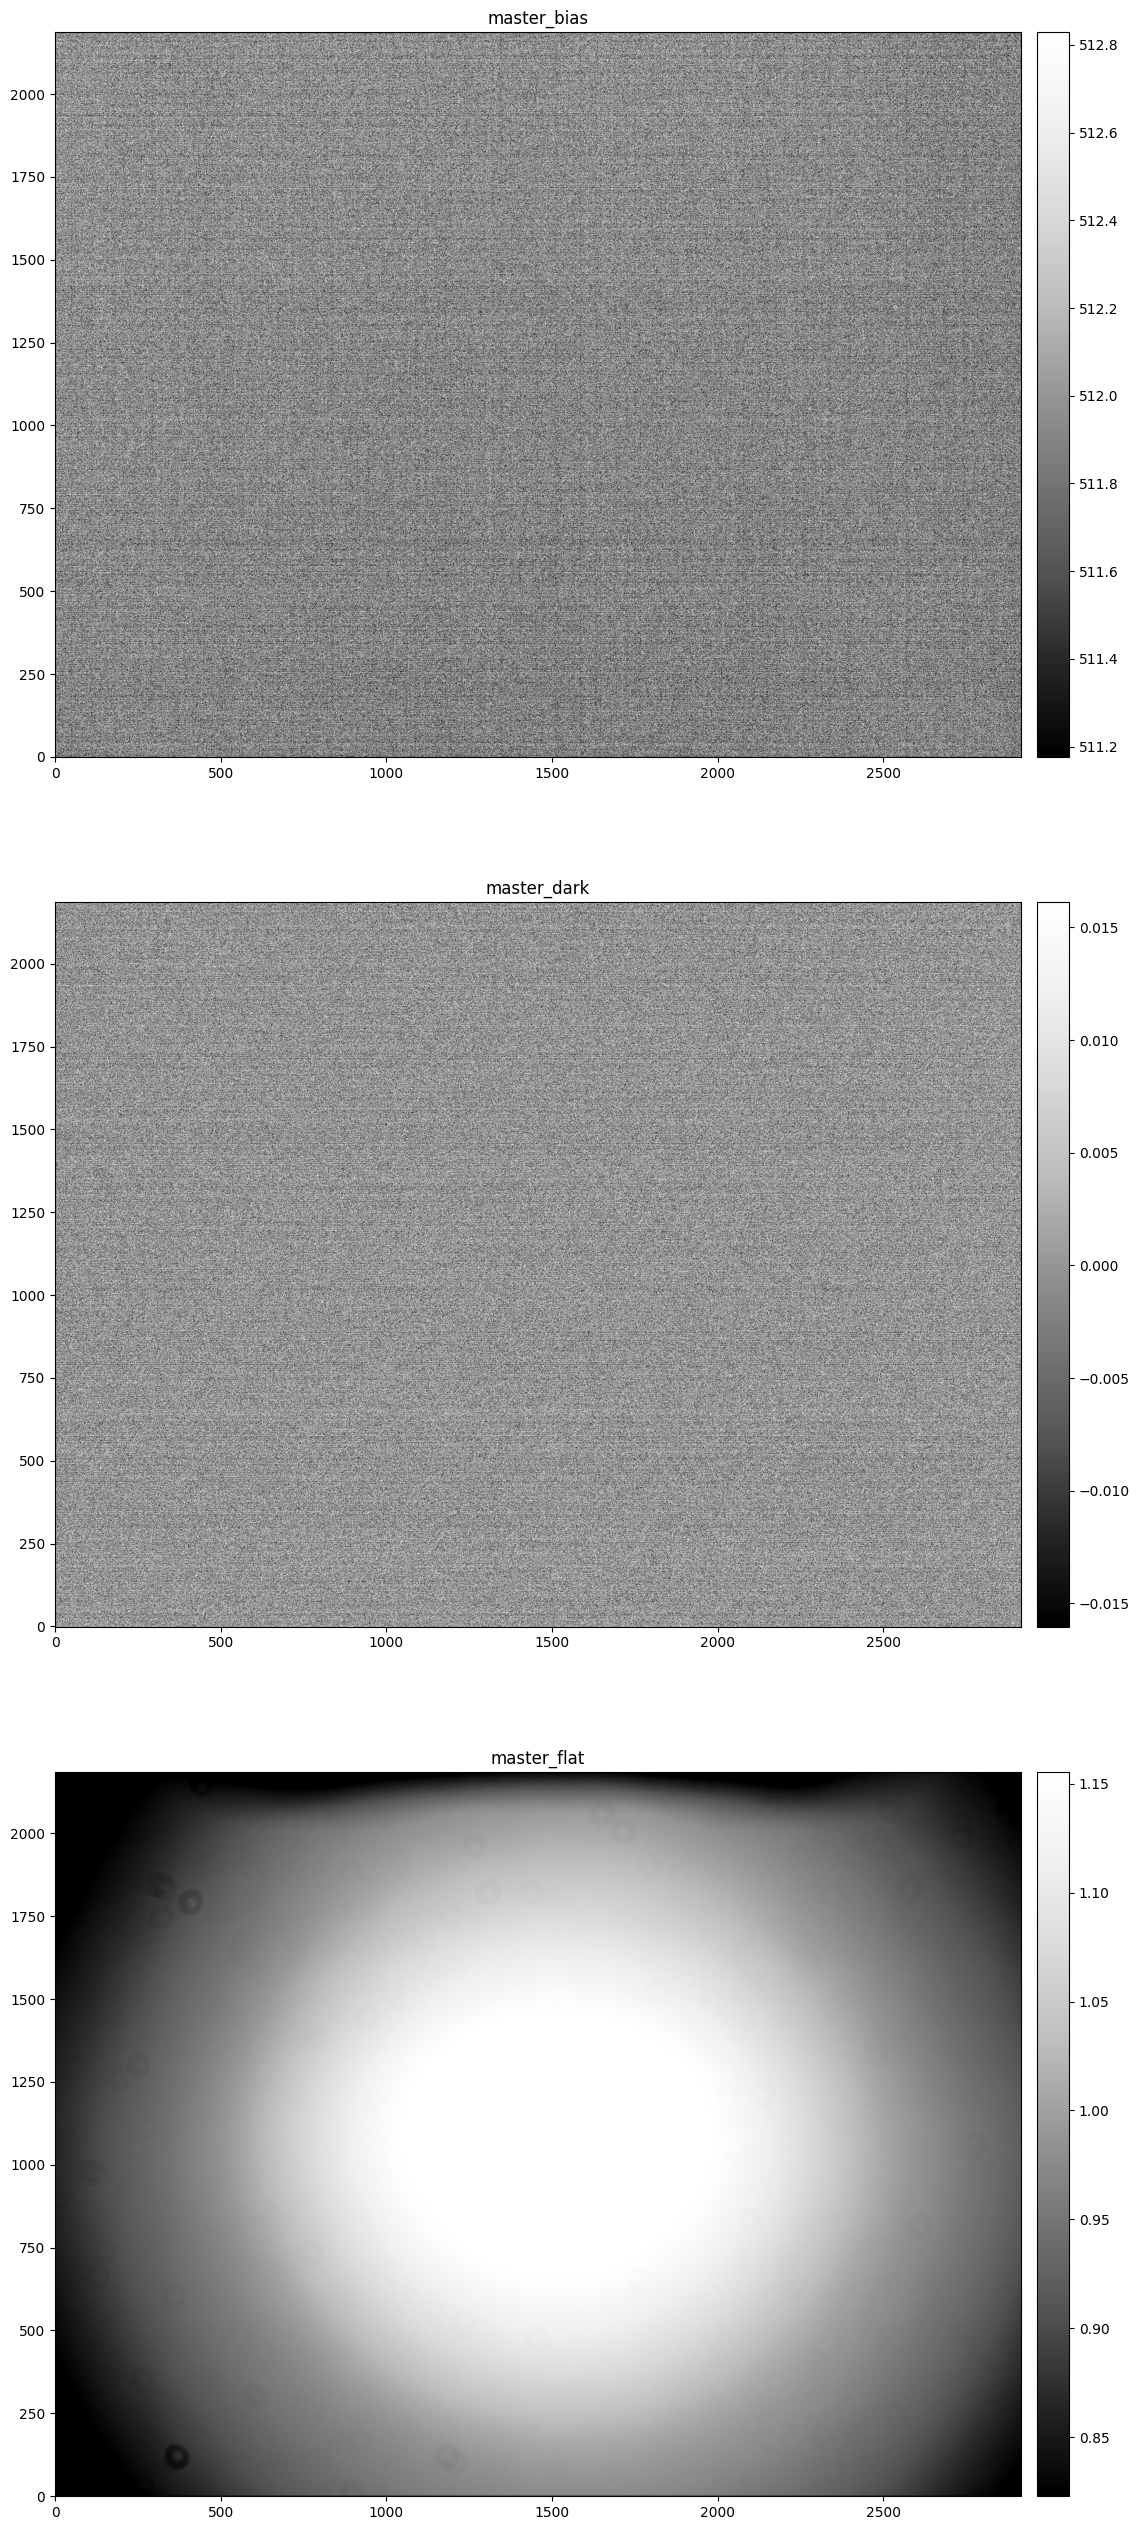

In [8]:
# show master calibration frames
calibration_frames = calibration_sequence[0]

fig, ax = plt.subplots(3,1, figsize=(16,32))

for i in range(3):
    if i == 0:
        data = calibration_frames.master_bias
        title = 'master_bias'
    elif i == 1:
        data = calibration_frames.master_dark
        title = 'master_dark'
    elif i == 2:
        data = calibration_frames.master_flat
        title = 'master_flat'

    # scale image nicely so we can see features
    contrast = 1
    interval = ZScaleInterval(contrast=contrast)
    vmin, vmax = interval.get_limits(data)
    
    im = ax[i].imshow(
        data, cmap="Greys_r", origin="lower", vmin=vmin, vmax=vmax,
    )

    # add colorbar
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(im, cax=cax)
    
    ax[i].set_title(title)

In [24]:
# main photometry extraction sequence
photometry_sequence = Sequence(
    [
        calibration_frames,  # calibration block (same as above)
        blocks.Trim(),
        blocks.PointSourceDetection(n=20, minor_length=8),  # fewer stars detection
        blocks.Cutouts(41),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.Gaussian2D(reference_image),  # modeling EPSF with initial guess
        blocks.ComputeTransformTwirl(reference_image),  # compute alignment
        blocks.AlignReferenceSources(reference_image),  # alignment
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # annulus background
        blocks.GetFluxes(
            "fwhm",
            airmass=lambda im: im.header["AIRMASS"],
            bjd=lambda im: im.header["BJD-OBS"],
            dx=lambda im: im.transform.translation[0],
            dy=lambda im: im.transform.translation[1],
        ),
    ]
)

In [25]:
# run photometry sequence
photometry_sequence.run(files["images"])

  0%|          | 0/110 [00:00<?, ?images/s]

In [26]:
# get raw fluxes from photometry sequence
raw_fluxes: Fluxes = photometry_sequence[-1].fluxes
fluxes = raw_fluxes.copy()

# set target found previously
fluxes.target = target_idx

(0.98, 1.02)

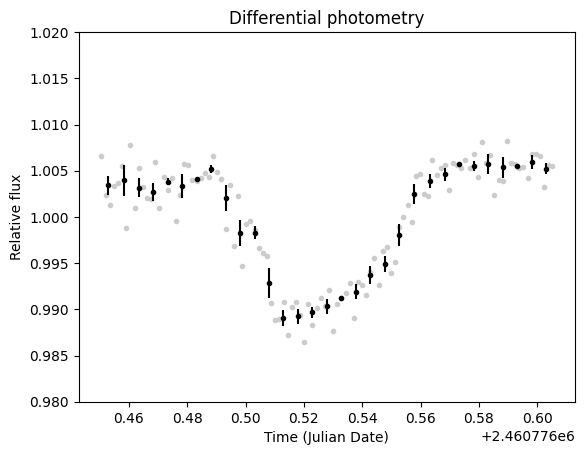

In [27]:
# a bit of cleaning
nan_stars = np.any(np.isnan(fluxes.fluxes), axis=(0, 2))  # stars with nan fluxes
fluxes = fluxes.mask_stars(~nan_stars)  # mask nans stars
fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3)  # sigma clipping

# differential photometry
diff_flux = fluxes.autodiff()

# plot
diff_flux.plot()
diff_flux.bin(0.005, estimate_error=True).errorbar()
plt.xlabel("Time (Julian Date)")
plt.ylabel("Relative flux")
plt.title("Differential photometry")
plt.ylim(0.98, 1.02)

In [28]:
# see comparisons used, aperture, and weights
diff_flux.comparisons, diff_flux.aperture, diff_flux.weights[diff_flux.aperture]

(array([0, 3, 6, 9, 8, 5]),
 18,
 array([885.72856082,   0.        ,   0.        , 812.63118837,
          0.        , 529.84085751, 584.97709745,   0.        ,
        568.53760137, 578.30106975,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ]))

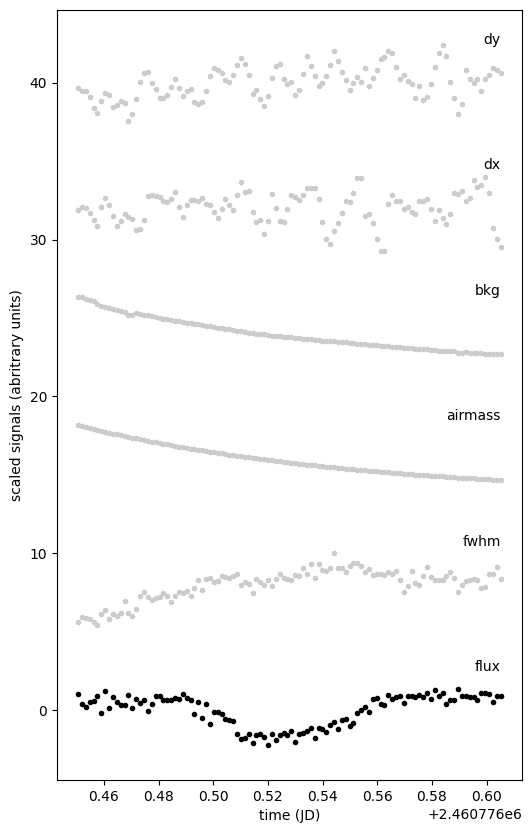

In [29]:
plt.figure(None, (6, 10))
ax = plt.subplot(xlabel="time (JD)", ylabel="scaled signals (abritrary units)")

for i, name in enumerate(["flux", "fwhm", "airmass", "bkg", "dx", "dy"]):
    y = diff_flux.df[name].copy()
    y = (y - np.mean(y)) / np.std(y) + 8 * i
    plt.text(diff_flux.time.max(), np.mean(y) + 2.5, name, ha="right")
    plt.plot(diff_flux.time, y, ".", c="0.8" if name != "flux" else "k")

In [30]:
# save photometry
diff_flux.save(f"./{reference_image.label}.flux")

## Manual photometry

Text(0.5, 1.0, 'Raw fluxes')

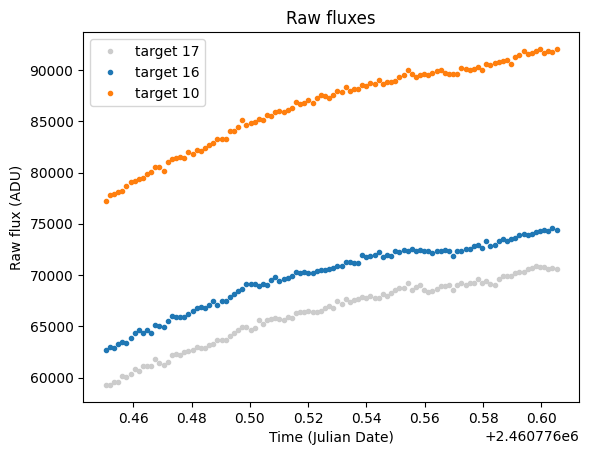

In [16]:
fluxes.aperture = 18 # play with different aperture sizes

# plot raw flux of difference stars
fluxes.target = 17
fluxes.plot(label=f'target {fluxes.target}')

fluxes.target = 16
fluxes.plot(label=f'target {fluxes.target}', color='C0')

fluxes.target = 10
fluxes.plot(label=f'target {fluxes.target}', color='C1')


plt.ylabel("Raw flux (ADU)")
plt.xlabel("Time (Julian Date)")
plt.legend()
plt.title("Raw fluxes")

(0.98, 1.02)

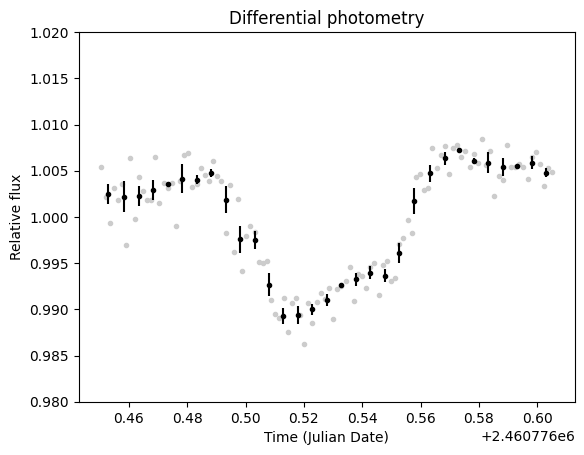

In [17]:
fluxes.aperture = 18

fluxes.target = target_idx
diff_flux = fluxes.diff([0, 1, 2, 3, 4])

diff_flux.plot()
diff_flux.bin(0.005, estimate_error=True).errorbar()
plt.xlabel("Time (Julian Date)")
plt.ylabel("Relative flux")
plt.title("Differential photometry")
plt.ylim(0.98, 1.02)

In [18]:
diff_flux.comparisons, diff_flux.aperture, diff_flux.weights[diff_flux.aperture]

(array([0, 4, 2, 1, 3]),
 18,
 array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]))

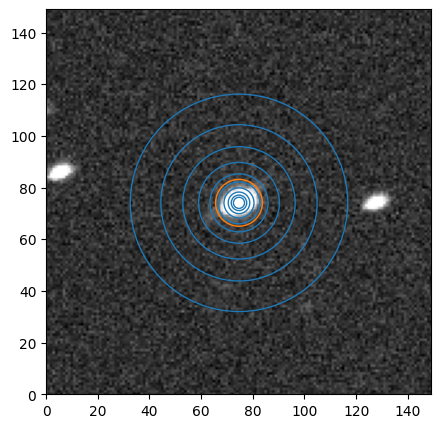

In [19]:
# visualise aperture of target

# we isolate the aperture photometry block
ap_phot_block: blocks.AperturePhotometry = photometry_sequence[9]
radii = ap_phot_block._radii.copy()

ref_cutout = reference_image.cutout(target_idx, 150)
ref_cutout.show(sources=False, figsize=5)
for r in radii[:20][::2] * reference_image.fwhm:
    ref_cutout.sources[0].plot(r * reference_image.fwhm, label=None, c="C0")
    
ref_cutout.sources[0].plot(radii[fluxes.aperture] * reference_image.fwhm, label=False, c="C1")

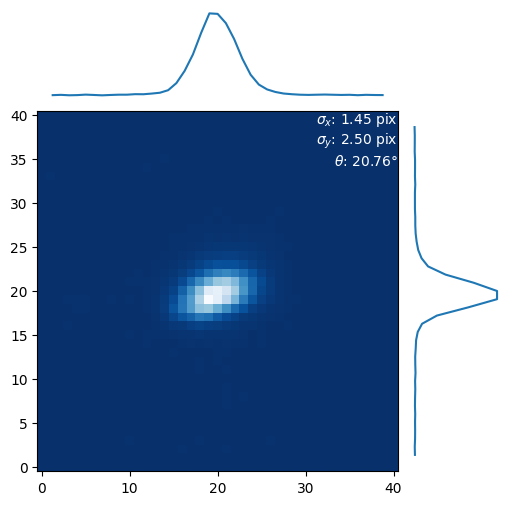

In [20]:
# visualise PSF
import matplotlib.gridspec as gridspec

def plot(image):
    fig = plt.figure(figsize=(6, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                           wspace=0.05, hspace=0.05)

    axt = fig.add_subplot(gs[0, 0])
    ax = fig.add_subplot(gs[1, 0])
    axr = fig.add_subplot(gs[1, 1])
    fig.add_subplot(gs[0, 1]).axis("off")

    ax.imshow(image.epsf.data, cmap="Blues_r", origin="lower")
    x, y = np.indices(image.epsf.shape)

    axt.plot(y[0], np.mean(image.epsf.data, axis=0), c="C0")
    axt.axis("off")

    axr.plot(np.mean(image.epsf.data, axis=1), y[0], c="C0")
    # axr.invert_xaxis()
    axr.axis("off")

    ax.text(
        1,
        1,
        f"$\sigma_x$: {image.epsf.params['sigma_x']:.2f} pix\n"
        f"$\sigma_y$: {image.epsf.params['sigma_y']:.2f} pix\n"
        f"$\\theta$: {image.epsf.params['theta']/np.pi*180:.2f}°",
        c="w",
        transform=ax.transAxes,
        ha="right",
        va="top",
    )

    # fig.suptitle(image.date.isoformat(), x=0.01, ha="left")
    plt.show()

# Here is the result
plot(reference_image)

## Acknowledgements

In [21]:
acknowledgement, bibtex = photometry_sequence.citations()

In [22]:
print(acknowledgement, "\n")
print(bibtex, "...")

This research made use of \textsf{prose} \citep{prose} and its dependencies (scipy \citep{scipy}, scikit-image \citep{scikit-image}, numpy \citep{numpy}, photutils \citep{photutils} and astropy \citep{astropy}). 


@ARTICLE{scipy,
  author  = {Virtanen, Pauli and Gommers, Ralf and Oliphant, Travis E. and
            Haberland, Matt and Reddy, Tyler and Cournapeau, David and
            Burovski, Evgeni and Peterson, Pearu and Weckesser, Warren and
            Bright, Jonathan and {van der Walt}, St{'e}fan J. and
            Brett, Matthew and Wilson, Joshua and Millman, K. Jarrod and
            Mayorov, Nikolay and Nelson, Andrew R. J. and Jones, Eric and
            Kern, Robert and Larson, Eric and Carey, C J and
            Polat, {\.I}lhan and Feng, Yu and Moore, Eric W. and
            {VanderPlas}, Jake and Laxalde, Denis and Perktold, Josef and
            Cimrman, Robert and Henriksen, Ian and Quintero, E. A. and
            Harris, Charles R. and Archibald, Anne M. and
      